<a href="https://colab.research.google.com/github/parksanghan/machine_learning_Deep_learning/blob/main/ai_chapter_06_ResNet_Batch_Normalization_Depth_Separable_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 잔차 연결

계층 구조가 깊으면 작은 층을 기페 쌓인 모델이 큰 층을 얇게 쌓은거보다 성능이 좋습니다. 하지만 기울기 소실 문제로 인해 층읗  쌓을 수 있는 정도의 한계가 있다.

$y = f4(f3(f2(f1(x))))$에서 $f4$의 출력에 기록된 오차를 기바으로 입력 된 각 함수의 파라미터를 조정하는 것이다. $f1$을 조정하려면 $f2,f3,f4$에 오차정보를 통과시켜야 한다. 이때 긱 힘수마다 잡음이 있는데 함수 연결이 너무깊다면 해당 잡음이 기울기를 점점 0으로 수렴하게 하고 역전파가 동작하지 않게 됩니다.

잔차연결 :  층이나 블록의 입력을 출력에 더하는 것
-> 입력을 블록의 출력에 다시 더하는 것을 통해 출력 크기가 입력크기와 같아야 한다.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs =  keras.Input(shape=(32,32,3))
# input 이 컨브넷 층으로 필터 통과 깊이 32 , 필터 3X3
x = layers.Conv2D(32, 3, activation="relu")(inputs)
# 해당 층을 x 로 지정
residual = x
# 필터수가 64개로 증가한 층에 다시 연결
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
# 잔차 변수의 필터수와 블록의 필터수를 같게 만들기
residual = layers.Conv2D(64,1)(residual)
# 블록의 출력과 잔차를 더하기
x = layers.add([x,residual])




첫 번째 층에서 필터를 통과한 출력을 잔차(residual)로 저장합니다. 이 잔차는 첫 번째 층에서 계산된 값입니다.

예를 들어, x = layers.Conv2D(32, 3, activation="relu")(inputs)에서 x가 첫 번째 컨볼루션 층의 출력이며, 이 값을 residual에 저장합니다.
잔차의 필터 수를 맞추기 위해 1x1 컨볼루션을 사용합니다. 이는 잔차와 다음 층의 출력의 필터 수가 맞지 않기 때문입니다. 필터 수를 맞춰주는 이유는 두 값을 더할 때, 차원이 맞아야 하기 때문입니다.

여기서 residual = layers.Conv2D(64, 1)(residual)은 1x1 필터를 사용해 잔차의 필터 수를 64개로 늘려줍니다.
다음 층의 출력과 잔차를 더합니다.

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)에서 나온 두 번째 층의 출력과, 필터 수를 맞춘 잔차 residual을 더합니다.
더하는 작업은 x = layers.add([x, residual])에서 이루어집니다.

In [ ]:
x

<KerasTensor shape=(None, 30, 30, 64), dtype=float32, sparse=False, name=keras_tensor_4>

In [ ]:
residual

<KerasTensor shape=(None, 30, 30, 64), dtype=float32, sparse=False, name=keras_tensor_3>

In [ ]:
# 최대 풀링 층을 가진 잔차 블록
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
# 맥스 풀링으로 인해 다운샘플링 된 것, 스트라이드로 잔차층도 동일하게 만들어주기.
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

잔차 블록에 최대 풀링을 추가하여 입력을 다운 샘플링하면서 잔차연결을 구성합니다. 최대 풀링은 입력의 크기를 줄이는 동시에 특징을 추출하는데 이때 공간적크기를 맞춰주며 잔차 연결과 결합하여 네트워크가 깊어져도  손실이 줄어듭니다.

### 배치 정규화

정규화란 머신러닝 모델에 주입되는 샘플들을 균일하게 만드는 광범위한 방법이다. 모델이 학습하고 새로운 데이터에 잘 일반화되도록 돕는다. 이전 예제들에서는 모델에 데이터를 주입하기 전 정규화를 진행하였지만, 정규화는 네트워크에서 일어나는 모든 변환 후에도 필요할 수 있다

 즉 정규화된 입력 데이터에 대해 출력데이터또한 동일한 분포를 가질 것이라고 기대하기 어렵다는 것이다.

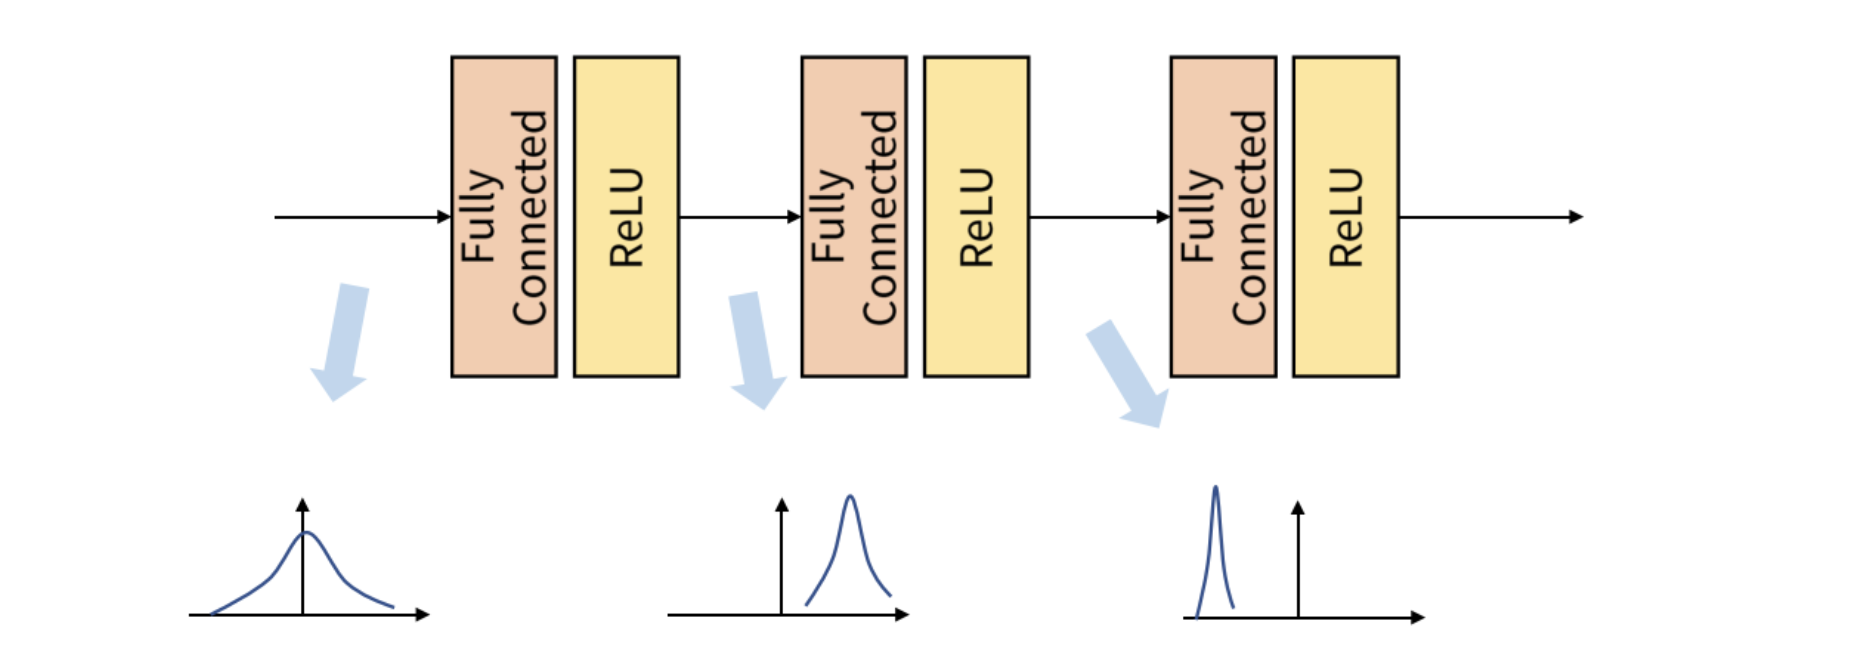

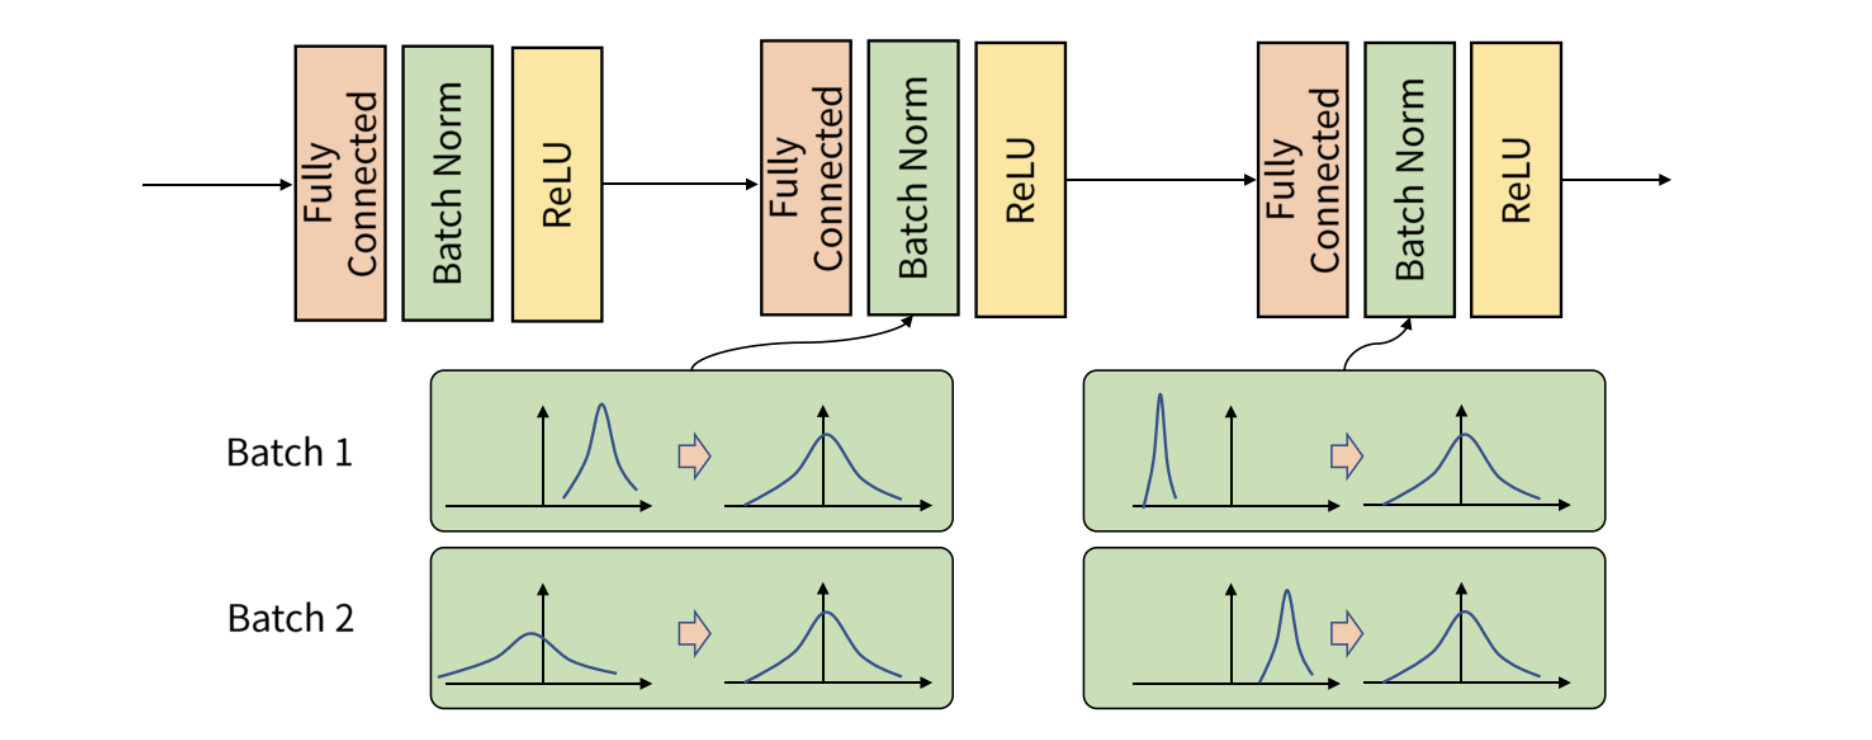

### 깊이별 분리 합성곱

이 층은 입력 채널별로 따로따로 공간 방향의 합성곱을 수행한다. 그 다음 점별합성곱을 통해 출력 채널을 합친다. 이는 공간 특성의 학습과 채널 방향 특성의 학습을 분리하는 효과를 낸다.

공간상의 위치는 높은 상관관계를 가지나, 채널 간에는 매우 독립적이라는 가정에 의존
깊이별 분리 합성곱은 일반 합성곱보다 훨씬 적은 개수의 파라미터를 사용하고 더 적은 수의 연산을 수행하면서 유사한 표현 능력을 가지고 있다. 수렴이 더 빠르고 쉽게 과대적합되지 않음.

모델은 반복되는 층 블록으로 조직되어야한다.(합성곱+최대풀링)
특성 맵의 공간방향 크기가 줄어듦에 따라 필터가 증가해야한다.
깊고 좁은 아키텍처가 얕고 넓은 것보다 낫다.
층 블록에 잔차 연결을 추가하면 깊은 네트워크 훈련에 도움이 된다.
합성곱 층 다음 배치정규화 층을 추가하면 도움이 된다.(relu이전)
Conv2D보다 파라미터 효율성이 좋은 SeparableConv2D사용하면 도움이 될 수 있다.
해당 사항들을 적용한것이 Xception 모델과 유사합니다.


In [ ]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

In [ ]:
# kaggle.json 파일을 업로드하세요.
from google.colab import files
files.upload()

In [ ]:

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip


In [ ]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:


inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

In [ ]:
# 강아지 vs 고양이 Xception Style로 모델만들기
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) # 데이터 증식

# 정규화
x = layers.Rescaling(1./255)(x)
# 처음 컨브넷층 조성(첫번째 에서는 특성 채널인 RGB는 매우 높은 상관관계를 가지므로 처음 층은 일반 컨브넷 층으로!)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)
# 필터수 점진적으로 증가를 위한 for문 작성
# 층이 많아지지만 우리는 배치정규화와 잔차연결 진행하기에 괜찮
for size in [32, 64, 128, 256, 512]:
	# 잔차연결을 위한 x복사
    residual = x
	# relu이전에 배치정규화
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual]) # 잔차연결

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)